In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import pandas_datareader as web

Get data of company using the specified API from 'start' to 'end' dates

In [2]:
start_date, end_date = "2000-01-01", "2021-12-31"
df = web.DataReader('BTC-USD', 'yahoo', start=start_date, end=end_date)

In [3]:
# goal is to predict closing prices
data = df.filter(['Close'])

In [4]:
# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_array = scaler.fit_transform(data) # numpy array

In [5]:
# create DataFrame from scaled array
scaled_data = pd.DataFrame()
scaled_data['Close'] = pd.DataFrame(scaled_data_array)

In [6]:
# use 75% of data to train the model
train_data_size = int(len(data) * 0.75)
print(train_data_size)

1136


In [7]:
# partition data into train and test data
train_data = scaled_data[0:train_data_size]
test_data = scaled_data[train_data_size:]

In [8]:
train_data_array = np.array(train_data)
train_data_array.shape

(1136, 1)

Split training data into inputs and targets

In [9]:
trail = 90 # number of days used to make prediction
x_train, y_train = [], []
for i in range(trail, train_data_array.shape[0]):
    x_train.append(train_data_array[i-trail:i])  # input will be closing prices from last 90 days
    y_train.append(train_data_array[i,0])       # target will be closing price one day after

In [10]:
# convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
x_train.shape, y_train.shape

((1046, 90, 1), (1046,))

Note that x_train and y_train have the closing prices up to 90 days before test_data begins

In [12]:
train_data.shape[0], train_data.shape[0] - trail

(1136, 1046)

In [13]:
# build model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
Dropout(1)
# model.add(Dropout(0.4))
# model.add(LSTM(units=70, return_sequences=True))
# model.add(Dropout(0.4))
# model.add(LSTM(units=100, return_sequences=False))
# model.add(Dropout(0.5))
model.add(Dense(units=1))

Metal device set to: Apple M1


2022-01-01 01:59:50.935275: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-01 01:59:50.935372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
# train the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=5)

2022-01-01 01:59:51.130599: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/5


2022-01-01 01:59:51.777315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:59:51.969250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:59:52.102461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:59:52.251139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 01:59:52.507041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 4s 64ms/step - loss: 0.0013
Epoch 2/5
33/33 [==============================] - 2s 48ms/step - loss: 1.2052e-04
Epoch 3/5
33/33 [==============================] - 2s 48ms/step - loss: 9.8242e-05
Epoch 4/5
33/33 [==============================] - 2s 49ms/step - loss: 9.9889e-05
Epoch 5/5
33/33 [==============================] - 2s 49ms/step - loss: 9.3276e-05


# Organize test data

Due to the 90 day gap, test_data must include the following

In [15]:
train_data.tail(trail) # recall trail = 90

,Close
1046,0.119719
1047,0.112319
1048,0.113504
1049,0.108960
1050,0.116948
...,...
1131,0.248871
1132,0.251520
1133,0.280955
1134,0.304187


Adjust test_data accordingly

In [16]:
test_data_adj = train_data.tail(trail).append(test_data)

In [17]:
# prepare array of test_data to make inputs and targets
test_data_array = np.array(test_data_adj)

In [18]:
x_test, y_test = [], []
for i in range(trail, test_data_array.shape[0]):
    x_test.append(test_data_array[i-trail:i])
    y_test.append(test_data_array[i])

In [19]:
# verify
len(x_test), len(y_test), test_data.shape, test_data.shape[0]

(379, 379, (379, 1), 379)

In [20]:
# prepare inputs and targets to be read
x_test, y_test = np.array(x_test), np.array(y_test)

In [21]:
# verify dims
x_test.shape, y_test.shape

((379, 90, 1), (379, 1))

In [22]:
scaled_predictions = model.predict(x_test) 
# scaled_predictions

2022-01-01 02:00:01.330128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 02:00:01.394101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-01 02:00:01.508882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [23]:
predictions = scaler.inverse_transform(scaled_predictions)
# predictions

In [24]:
# compute error
rmse = np.sqrt(np.mean(scaled_predictions - y_test)**2) # root mean squared error
rmse

0.015163523150033602

# Prepare data to be plotted

In [25]:
train = data[:train_data_size]
test = data[train_data_size:] # should have same length as predictions 
len(test)

379

In [26]:
# test

In [27]:
test.insert(loc=1, column='Predictions', value=predictions)
test

,Close,Predictions
Date,,
2020-12-19,23869.832031,20921.302734
2020-12-20,23477.294922,21709.667969
2020-12-21,22803.082031,22350.767578
2020-12-22,23783.029297,22737.179688
2020-12-23,23241.345703,23085.341797
...,...,...
2021-12-28,47588.855469,51551.230469
2021-12-29,46444.710938,51409.699219
2021-12-30,47178.125000,50878.554688


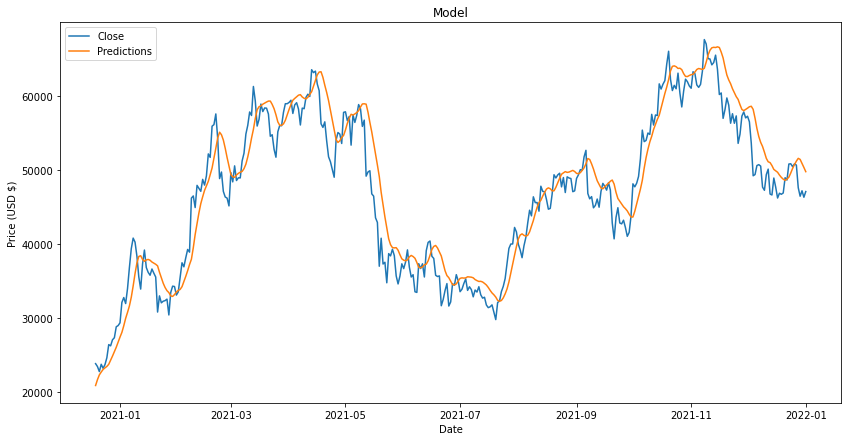

In [28]:
plt.figure(figsize=(14, 7))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Price (USD $)')
plt.plot(test[['Close', 'Predictions']])
plt.legend(['Close', 'Predictions'], loc="upper left")
plt.show()